Here, I want to understand the satellite statistics, i.e. what observables can separate on-plane and off-plane satellites.

Imports:

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from os.path import exists
sys.path.append("..")
from src.constants import MSUN, KPC, GYR
from src.simulation import Simulation
from src.satellites import sample_satellites

Set up and run simulations, save data:

In [2]:
dfile = "20220118_data.npz"
if not exists(dfile):

    # MW and DW params
    M_vir = 1e+12 * MSUN
    c_vir = 10
    a_DW = 5e-11
    l_DW = 10 * KPC

    # sample satellites
    pos, vel = sample_satellites(N_sat=1000, M_vir=M_vir, c_vir=c_vir, f_vesc=0.95)

    # set up simulations
    sim0 = Simulation(
        pos0=pos, vel0=vel,
        M_vir=M_vir, c_vir=c_vir,
        a_DW=0, l_DW=l_DW
    )
    sim1 = Simulation(
        pos0=pos, vel0=vel,
        M_vir=M_vir, c_vir=c_vir,
        a_DW=a_DW, l_DW=l_DW
    )

    # run simulation
    sim0.run(t_max=3e+18, N_snapshots=5000, dt=1e+12)
    sim1.run(t_max=3e+18, N_snapshots=5000, dt=1e+12)
    np.savez(dfile,
             x0 = sim0.positions / KPC, v0 = sim0.velocities / 1000,
             x1 = sim1.positions / KPC, v1 = sim1.velocities / 1000,
             t = sim0.times / GYR)

data = np.load(dfile)
pos0 = data['x0']
pos1 = data['x1']
vel0 = data['v0']
vel1 = data['v1']
t = data['t']

r0 = np.linalg.norm(pos0, axis=-1)
v0 = np.linalg.norm(vel0, axis=-1)
r1 = np.linalg.norm(pos1, axis=-1)
v1 = np.linalg.norm(vel1, axis=-1)

Plane metric: c/a ratio

In [3]:
r0 = np.linalg.norm(pos0, axis=-1)
r1 = np.linalg.norm(pos1, axis=-1)

N_snaps = 5001
h0 = np.zeros(N_snaps)
h1 = np.zeros(N_snaps)
f0 = np.zeros(N_snaps)
f1 = np.zeros(N_snaps)
for i in range(N_snaps):
    m0 = r0[i] < 400
    m1 = r1[i] < 400
    x0 = pos0[i, m0]
    x1 = pos1[i, m1]
    
    h0[i] = np.sqrt(np.mean(x0[:, 2]**2))
    h1[i] = np.sqrt(np.mean(x1[:, 2]**2))
    
    t1 = (r0[i, m0]**2)[:, None, None] * np.ones((m0.sum(), 3, 3)) * np.eye(3)[None]
    t2 = (x0[..., None] * x0[:, None])
    I = t1 - t2
    I = np.sum(I, axis=0)
    e = np.linalg.eigvals(I)
    f0[i] = e.min() / e.max()
    
    t1 = (r1[i, m1]**2)[:, None, None] * np.ones((m1.sum(), 3, 3)) * np.eye(3)[None]
    t2 = (x1[..., None] * x1[:, None])
    I = t1 - t2
    I = np.sum(I, axis=0)
    e = np.linalg.eigvals(I)
    f1[i] = e.min() / e.max()

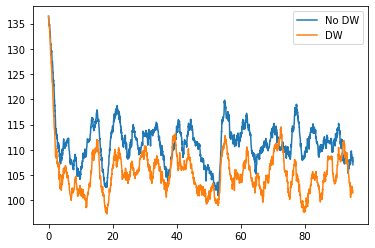

In [4]:
plt.plot(t, h0, label="No DW")
plt.plot(t, h1, label="DW")
plt.legend()

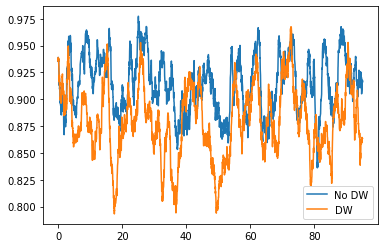

In [5]:
plt.plot(t, f0, label="No DW")
plt.plot(t, f1, label="DW")
plt.legend()

In [6]:
z0 = np.abs(pos0[..., 2])
z1 = np.abs(pos1[..., 2])
m0 = np.all(z0 < 50, axis=0)
m1 = np.all(z1 < 50, axis=0)
print(m0.sum(), m1.sum())

124 206


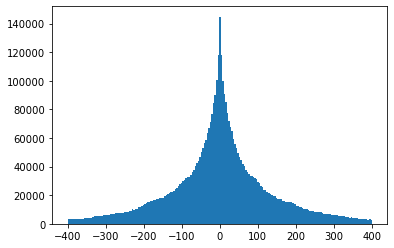

In [7]:
plt.hist(pos0[..., 2].flatten(), np.linspace(-400, 400, 200));

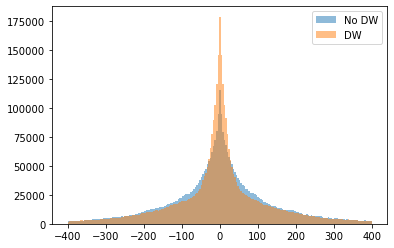

In [8]:
plt.hist(pos0[1000:, :, 2].flatten(), np.linspace(-400, 400, 200), alpha=0.5, label="No DW");
plt.hist(pos1[1000:, :, 2].flatten(), np.linspace(-400, 400, 200), alpha=0.5, label="DW");
plt.legend();

In [10]:
v

(5001, 1000, 3)